In [2]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [3]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
import notebook_utils as nbu

# Properties of Trained Tokenizers

In [5]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'tr', 'zh', 'el', 'es', 'en')
multil_string = '-'.join(languages)
all_languages = languages + (multil_string,)

alphas = ('0.0', '0.25', '0.5', '0.75', '1.0')
alphas_num = np.array([float(alpha) for alpha in alphas])
NV_mono = 20000
NV_multi = 120000

NV_per_language = (NV_mono, NV_mono, NV_mono, NV_mono, NV_mono, NV_mono, NV_multi)

tok_type = "sp-unigram"

token_stats = nbu.get_token_stats(tokenizer_dir, tok_type, all_languages, alphas, NV_per_language)


In [6]:
vocab_sizes = {alpha: {lang: len(token_stats[alpha][lang]) for lang in all_languages} for alpha in alphas}

Peculiarly, some of the tokens are used 0 times in the training data. 

In [7]:
ub = nbu.UnicodeBlocks("unicode_blocks.tsv")

char_stats = nbu.get_char_stats(token_stats, all_languages, alphas, lambda x: x, skip_tokens=["<s>", "</s>"])
unicode_blocks_stats = nbu.get_char_stats(token_stats, all_languages, alphas, ub.get_block, skip_tokens=["<s>", "</s>"])

### Measure size of alphabet in the vocab

In [18]:
# compute alphabet occurences
alphabet_occurence = nbu.apply_to_all_token_stats(token_stats, nbu.get_alphabet_occurence)
pd_alphabet_occurence = nbu.stats_to_pandas(alphabet_occurence)
total_occurence = nbu.apply_to_all_token_stats(token_stats, nbu.get_total_occurence)
pd_total_occurence = nbu.stats_to_pandas(total_occurence)

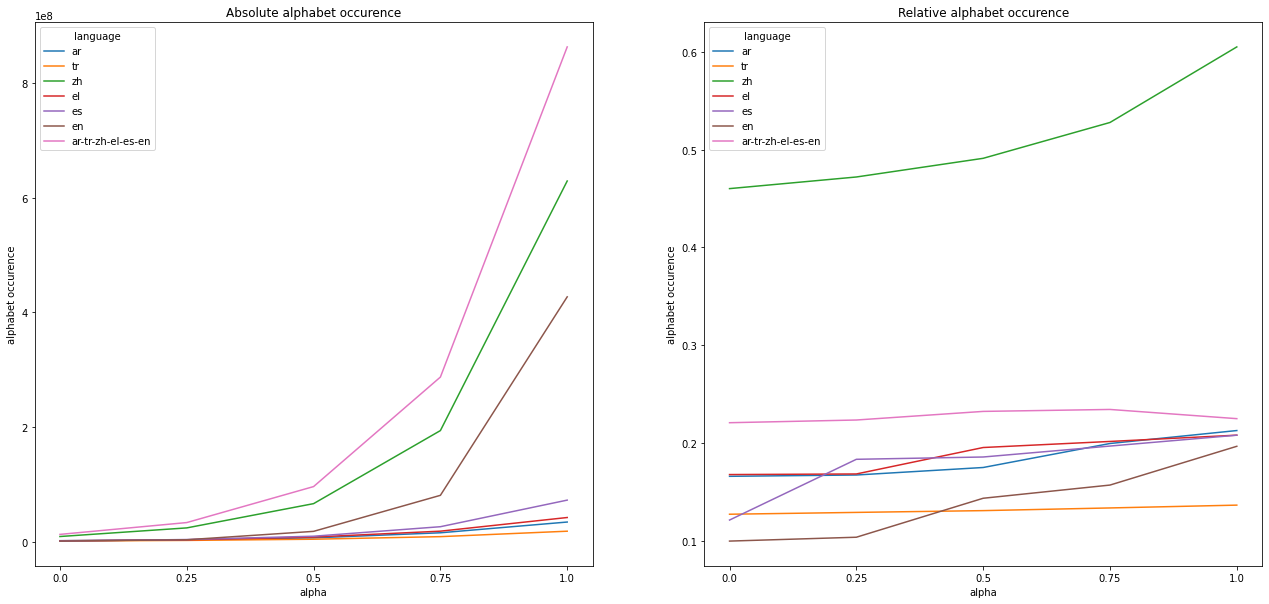

In [19]:
pd_relative_alphabet_occurence = pd_alphabet_occurence / pd_total_occurence

# plot the absolute and relative alphabet occurence
# x will be the alpha values
# y will be the absolute and relative occurence
# hue will be the language

fig, ax = plt.subplots(1, 2, figsize=(22, 10))
sns.lineplot(data=pd_alphabet_occurence, x="alpha", y="value", hue="language", ax=ax[0])
sns.lineplot(data=pd_relative_alphabet_occurence, x="alpha", y="value", hue="language", ax=ax[1])
# set titles and labels
ax[0].set_title("Absolute alphabet occurence")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("alphabet occurence")
ax[1].set_title("Relative alphabet occurence")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("alphabet occurence")
plt.show()

In [11]:
# plt.figure()

# for lang, alphabet_size in alphabet_sizes.items():
#     if lang == "multilingual":
#         plt.plot(alphas_num, alphabet_size/NV_multi, label=lang, alpha=0.6)
#     else:
#         plt.plot(alphas_num, alphabet_size/NV_mono, label=lang, alpha=0.6)
    
# plt.xlabel("Alpha")
# plt.ylabel("Alphabet as share of vocab")
# plt.legend()

In [43]:
# compute overlaps
skip_tokens = ["<s>", "</s>", "▁"]
overlap_maps = {}
for alpha in alphas:
    # go through all language pairs with replacement
    overlap_list = []
    for lang1, lang2 in itertools.product(all_languages, repeat=2):
        # compute how many times tokens shared between lang1 and lang2 occur in lang2
        shared_tokens = token_stats[alpha][lang1].keys() & token_stats[alpha][lang2].keys()
        # filter out special tokens
        shared_tokens = [token for token in shared_tokens if token not in skip_tokens]
        shared_token_freqs = [(token, token_stats[alpha][lang2][token]) for token in shared_tokens]
        shared_token_freqs.sort(key=lambda x: x[1], reverse=True)

        special_token_freqs = [(token, token_stats[alpha][lang2][token]) for token in skip_tokens]

        # get total token count for lang2
        total = total_occurence[alpha][lang2] - sum([freq for token, freq in special_token_freqs])
        shared = sum([freq for token, freq in shared_token_freqs])
        
        print(alpha, lang1, lang2, total, shared, shared/total, shared_token_freqs[:10])
        # overlap = nbu.get_overlap(token_stats[alpha][lang1], token_stats[alpha][lang2])
        # overlaps[(alpha, lang1, lang2)] = overlap
        overlap_list.append(shared/total)
    overlap_maps[alpha] = np.array(overlap_list).reshape((len(all_languages), len(all_languages)))

0.0 ar ar 7689100 7689100 1.0 [('،', 184862), ('▁في', 144412), ('▁من', 128987), ('.', 119442), ('ة', 91965), ('▁و', 91019), ('ه', 86326), ('ي', 74666), ('ا', 71259), ('▁على', 70625)]
0.0 ar tr 6348789 1486771 0.23418182585686814 [(',', 183390), ('.', 71208), ('n', 52413), ('▁bu', 31008), ('a', 28576), ('i', 27851), ('e', 27503), ('k', 24203), (':', 23384), (')', 19400)]
0.0 ar zh 16787562 2128809 0.12680870515921253 [(',', 450470), (':', 61953), (')', 51911), ('(', 45228), ('“', 45119), ('”', 43524), ('大', 37371), ('.', 28836), ('!', 28668), ('?', 28354)]
0.0 ar el 7085805 1363776 0.19246592306731558 [(',', 193368), ('.', 149437), ('ς', 111276), ('ν', 37190), ('α', 31613), ('ι', 31395), (':', 28251), ('ο', 26801), ('ό', 24953), ('ή', 24394)]
0.0 ar es 6309594 1155676 0.18316170580864632 [(',', 203371), ('.', 145270), ('s', 85869), ('o', 44102), ('n', 30816), ('a', 22908), (':', 21640), ('r', 17266), ('e', 16045), ('▁La', 15424)]
0.0 ar en 6456008 1511914 0.23418713235795247 [('▁the', 2

<Figure size 432x288 with 0 Axes>

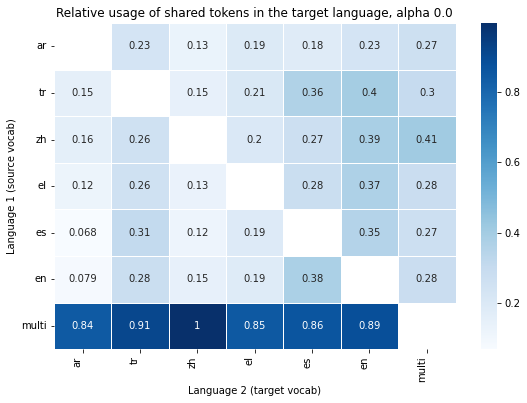

<Figure size 432x288 with 0 Axes>

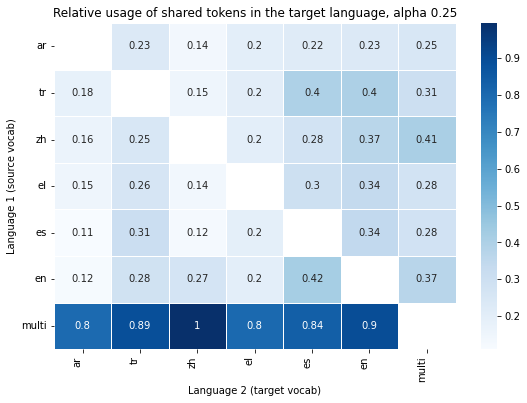

<Figure size 432x288 with 0 Axes>

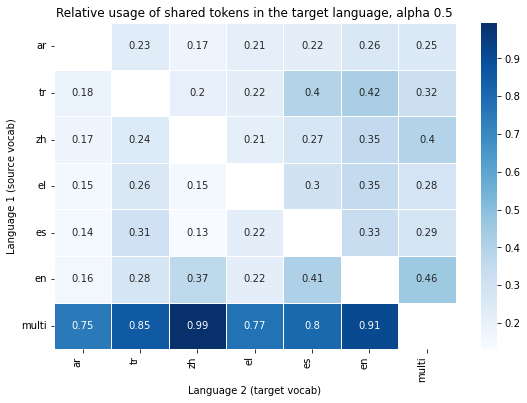

<Figure size 432x288 with 0 Axes>

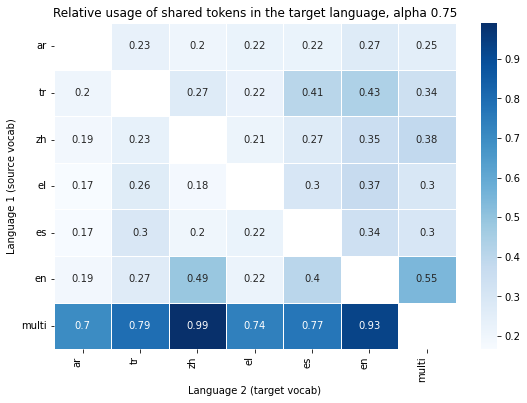

<Figure size 432x288 with 0 Axes>

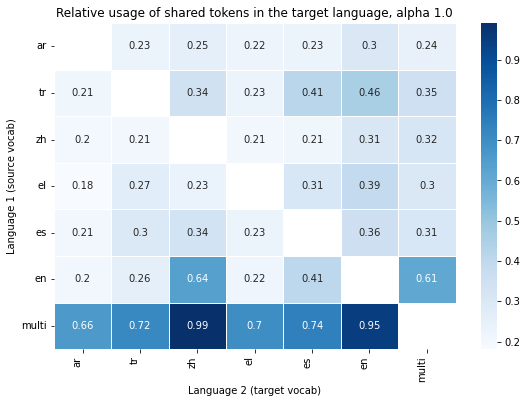

In [42]:
for alpha in alphas:
    plt.figure()


    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps[alpha].shape[0], dtype='bool')
    sns.heatmap(overlap_maps[alpha], mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    renamed_all_languages = [lang.replace("ar-tr-zh-el-es-en", "multi") for lang in all_languages]

    ax.set_xticks(np.arange(len(renamed_all_languages)) + 0.5, labels=renamed_all_languages)
    ax.set_yticks(np.arange(len(renamed_all_languages)) + 0.5, labels=renamed_all_languages)
    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    # set labels
    ax.set_xlabel("Language 2 (target vocab)")
    ax.set_ylabel("Language 1 (source vocab)")

    ax.set_title(f"Relative usage of shared tokens in the target language, alpha {alpha}")
    plt.show()

# Old cells below
----

### Measure token acceptance in m-lingual vocab

In [16]:
accepted_shares = {}
for lang in languages:
    accepted_shares[lang] = np.array([tokens_acceptance(mono_tokenizers[f"alpha{alpha}"][lang],
                                                       multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])


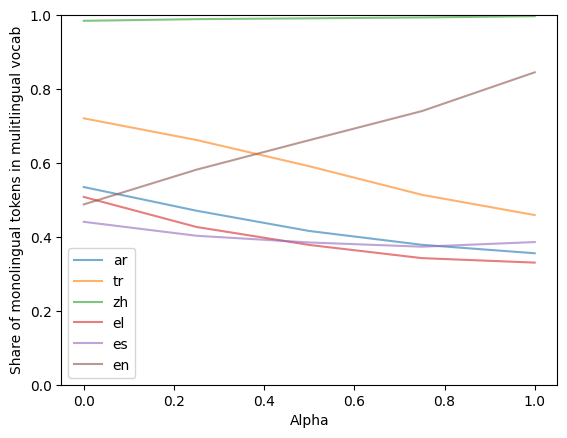

In [17]:
plt.figure()

for lang, accepted_share in accepted_shares.items():
        plt.plot(alphas_num, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab")
plt.ylim([0.0, 1.0])
plt.legend()

Without considering alphabet.

In [18]:
accepted_shares_no_alphabet = {}
for lang in languages:
    accepted_shares_no_alphabet[lang] = np.array([tokens_acceptance_no_alphabet(mono_tokenizers[f"alpha{alpha}"][lang],
                                                       multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

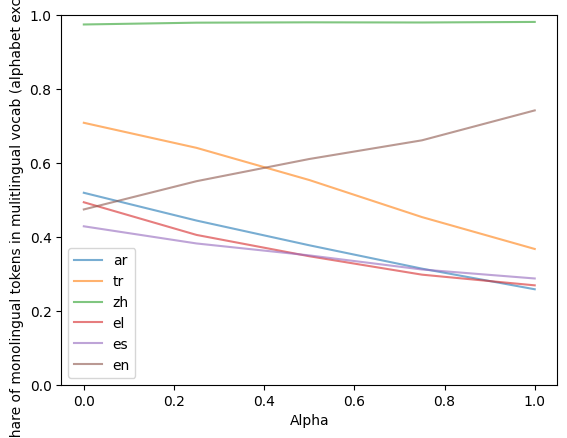

In [19]:
plt.figure()

for lang, accepted_share in accepted_shares_no_alphabet.items():
        plt.plot(alphas_num, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab (alphabet excluded)")
plt.ylim([0.0, 1.0])
plt.legend()

### Measure overlap between languages

In [20]:
all_overlap_shares_exact = np.array([tokens_overlap_exact([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages],
                                                    multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

all_overlap_shares = np.array([tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages],
                                              multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

In [21]:
np.abs(all_overlap_shares_exact - all_overlap_shares )

array([0., 0., 0., 0., 0.])

**exact means that we take into account mulilingual tokenizer in the intersection. It shouldn't have any influence because monolingual overlap should be included in it. In practice there are minor differences between two resulting sets.**

In [22]:
for alpha in alphas:
    print(f"Overlap for all languages for alpha: {alpha}")
    print_tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages], multi_tokenizer[f"alpha{alpha}"])
    

Overlap for all languages for alpha: 0.0
['!', '"', '#', '$', '%', '&', "'", '(', ')', '):', '*', '+', ',', '-', '-1', '-12', '-2', '.', '...', '................', '.com', '.com/', '/', '0', '00', '000', '01', '04', '05', '06', '07', '08', '09', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '200', '2010', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '400', '42', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '55', '56', '57', '58', '59', '6', '60', '61', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '99', ':', ';', '<', '</s>', '<mask>', '<pad>', '<s>', '<unk>', '=', '>', '?', '@', 'A', 'AL', 'AN', 'B', 'Book', 'C', 'D', 'E', 'ER', 'F', 'G', 'GB', 'H', 'I', 'IP', 'IS', 'J

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '-1', '.', '...', '.com', '/', '0', '00', '000', '01', '02', '03', '04', '05', '07', '08', '09', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '200', '2017', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '400', '42', '44', '45', '46', '47', '48', '49', '5', '50', '52', '55', '56', '58', '6', '60', '600', '64', '65', '66', '68', '7', '70', '75', '77', '78', '8', '80', '88', '9', '90', '95', '96', '97', '98', '99', ':', ';', '<', '</s>', '<mask>', '<pad>', '<s>', '<unk>', '=', '>', '?', '@', 'A', 'AR', 'B', 'C', 'D', 'E', 'ER', 'F', 'G', 'H', 'I', 'ID', 'IN', 'IP', 'J', 'K', 'L', 'M', 'N', 'O', 'OS', 'P', 'PS', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'age', 'and', 'ang', 'ard', 'art', 'b', 'c', 'ca', 'ch', 'com', 'd', 'do', 'e', 'er', 'est', 'ex', 'f', 'g', '

Text(0, 0.5, 'Overlap between all languages')

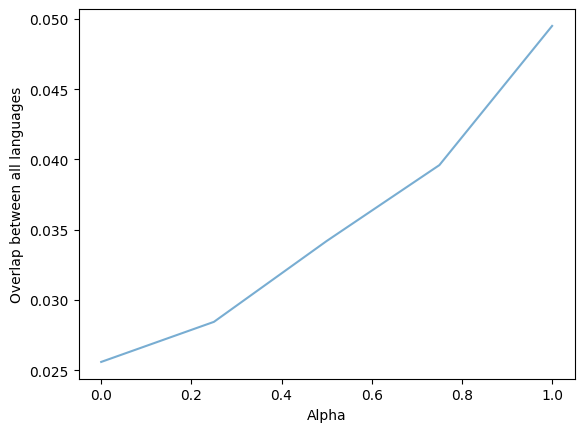

In [23]:
plt.figure()

plt.plot(alphas_num, all_overlap_shares_exact, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Overlap between all languages")



## Measuring Overlap between pairs of languages

In [24]:
overlap_maps = {}

for alpha in alphas:
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang1],
                                                 mono_tokenizers[f"alpha{alpha}"][lang2]],
                                               multi_tokenizer[f"alpha{alpha}"]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps[f"alpha{alpha}"] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

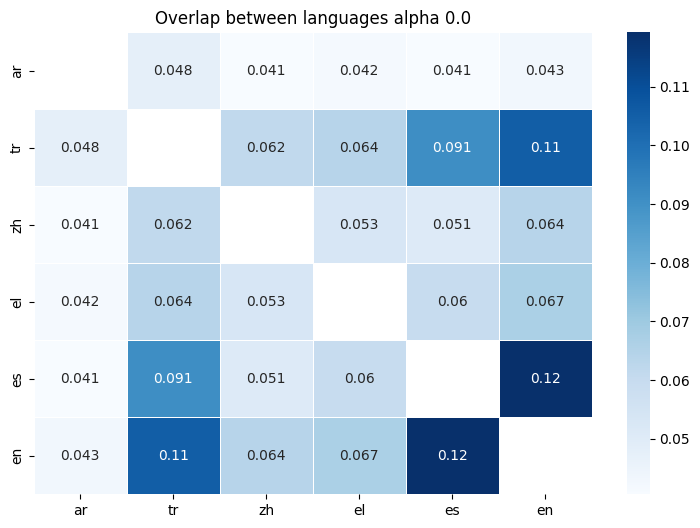

<Figure size 640x480 with 0 Axes>

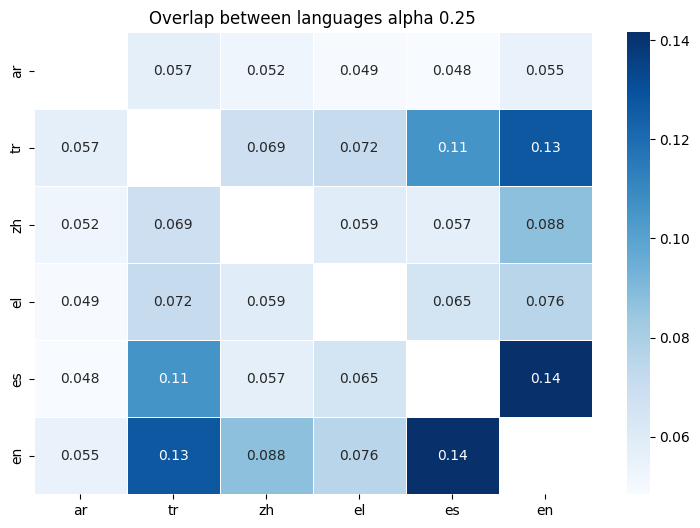

<Figure size 640x480 with 0 Axes>

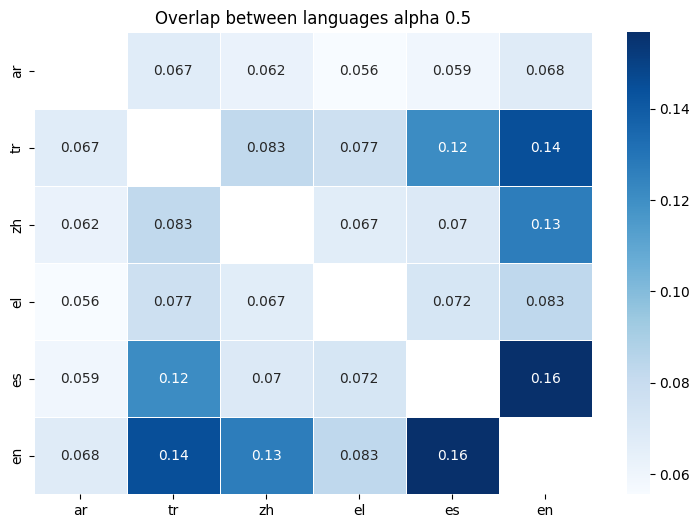

<Figure size 640x480 with 0 Axes>

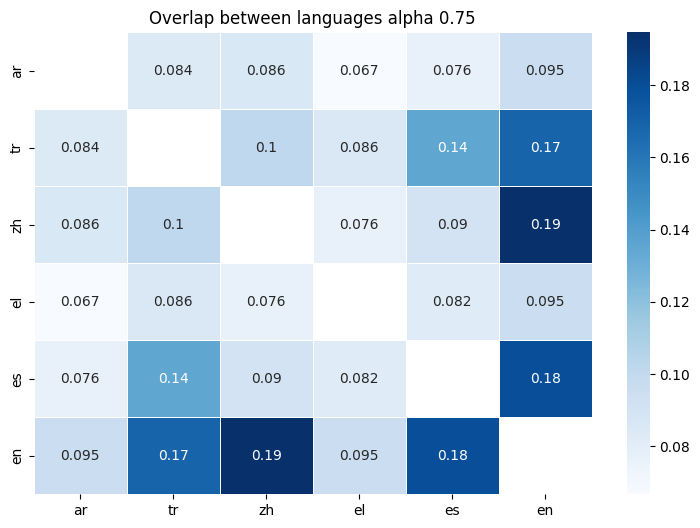

<Figure size 640x480 with 0 Axes>

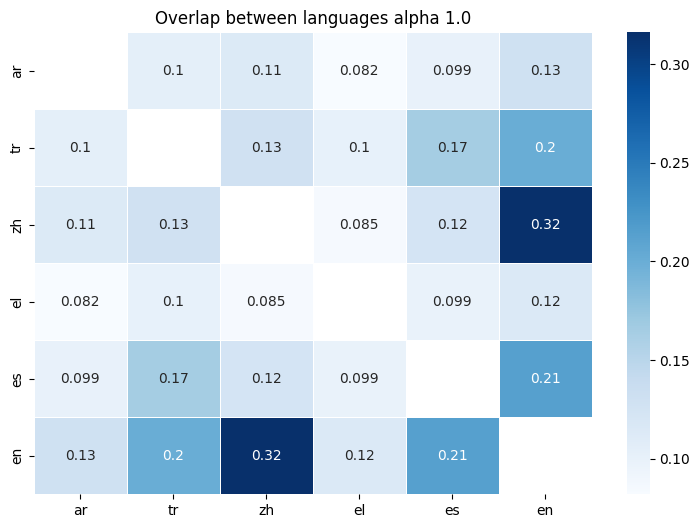

In [25]:
for alpha in alphas:
    plt.figure()


    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps[f"alpha{alpha}"].shape[0], dtype='bool')
    sns.heatmap(overlap_maps[f"alpha{alpha}"], mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages alpha {alpha}")
    plt.show()

**Overlaps are so small because it's normalized for**

## Without alphabet

In [26]:
overlap_maps_no_alphabet = {}

for alpha in alphas:
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap_exact_no_alphabet([mono_tokenizers[f"alpha{alpha}"][lang1],
                                                 mono_tokenizers[f"alpha{alpha}"][lang2]],
                                               multi_tokenizer[f"alpha{alpha}"]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps_no_alphabet[f"alpha{alpha}"] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

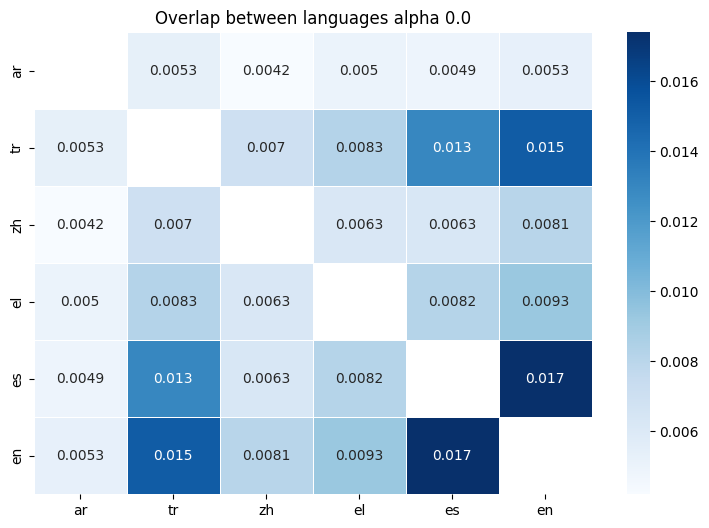

<Figure size 640x480 with 0 Axes>

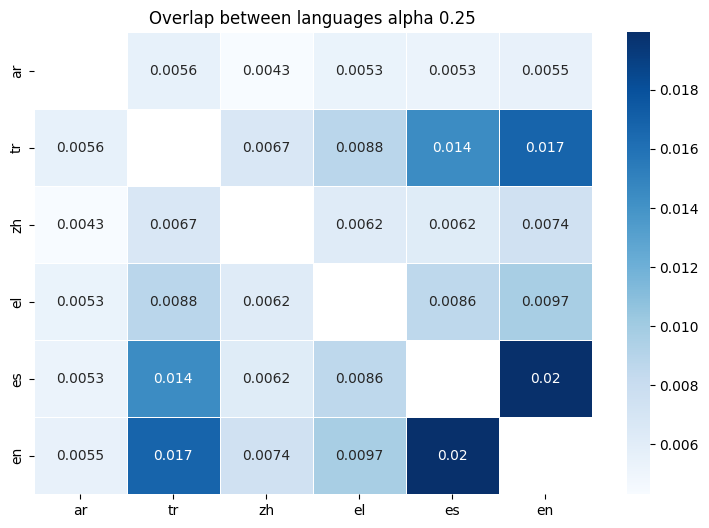

<Figure size 640x480 with 0 Axes>

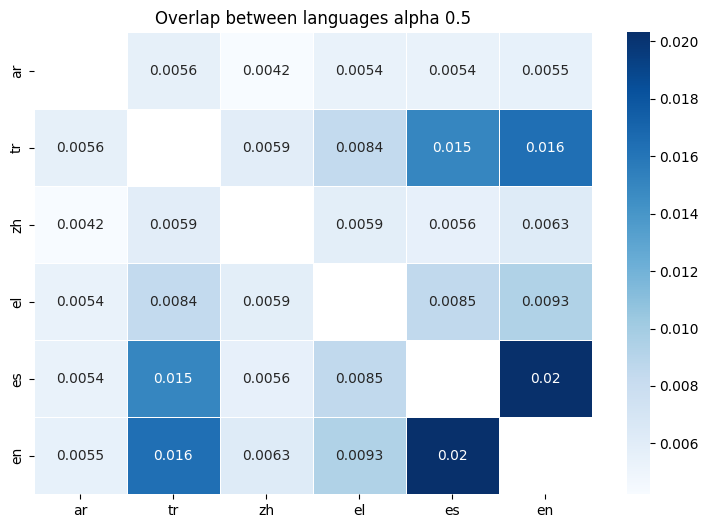

<Figure size 640x480 with 0 Axes>

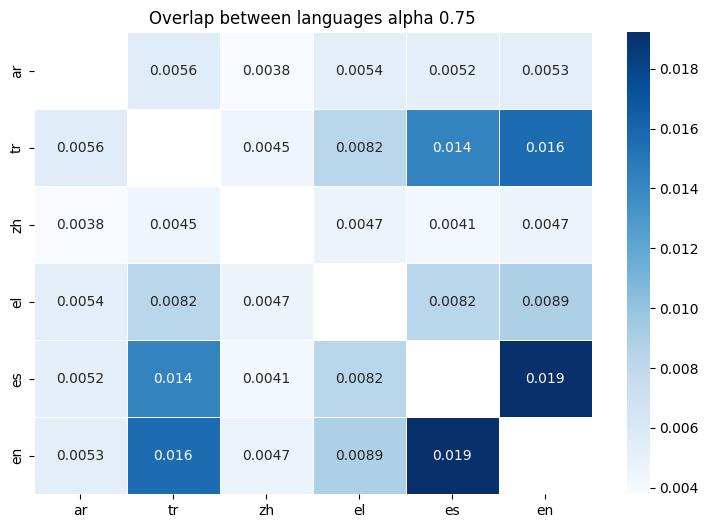

<Figure size 640x480 with 0 Axes>

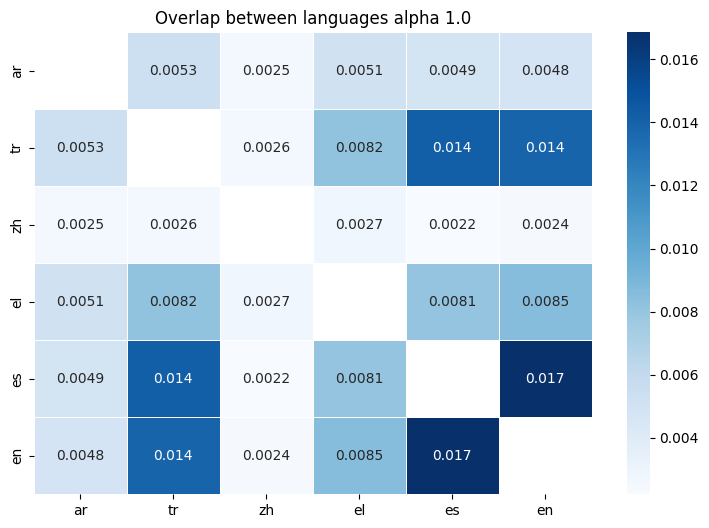

In [27]:
for alpha in alphas:
    plt.figure()


    
    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps_no_alphabet[f"alpha{alpha}"].shape[0], dtype='bool')
    sns.heatmap(overlap_maps_no_alphabet[f"alpha{alpha}"], annot=True, mask=mask, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages alpha {alpha}")
    plt.show()